In [1]:
import pandas as pd
import random
import torch
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read and format data
df = pd.read_csv('NationalNames.csv')

names = [name.lower() for name in list(set(df['Name']))]
print(names[:5])
print('Num names:',len(names))

longest_name = max(len(name) for name in names) + 2 # including first and last '.'

['salette', 'cici', 'paycen', 'monish', 'diadra']
Num names: 93889


In [4]:
# build vocabulary and mappings
chars = [c.lower() for c in sorted(list(set(''.join(names))))]
ctoi = {c:i for i,c in enumerate(chars)}
ctoi['.'] = 26
itoc = {i:c for c,i in ctoi.items()}
print(itoc)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: '.'}


In [17]:
# shuffle names
random.seed(10)
random.shuffle(names)
print(names[:5])

['samyrah', 'tinothy', 'britini', 'lhiam', 'eh']


In [18]:
# split dataset
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))
names_tr = names[:n1]
names_val = names[n1:n2]
names_test = names[n2:]

In [19]:
X_size = 27 # input vector size (one-hot encoded char) (includes '.' character indicating start/end of name)
Y_size = 27 # output vector size (one-hot encoded char) (includes '.' character indicating start/end of name)

In [20]:
# 1st dim = name, 2nd dim = char, 3rd dim = one-hot encoding
def build_dataset(names):
    X = torch.zeros(len(names), longest_name, X_size)
    Y = torch.zeros(len(names), longest_name, Y_size)
    
    for i,name in enumerate(names):
        for j,char in enumerate('.' + name):
            X[i,j,:] = F.one_hot(torch.tensor(ctoi[char]), num_classes=X_size)
            Y[i,j,:] = F.one_hot(torch.tensor(ctoi[(name + '.')[j]]), num_classes=Y_size) # lookahead to next char for expected output
            
    return X,Y

Xtr,   Ytr = build_dataset(names_tr)
Xval,  Yval = build_dataset(names_val)
Xtest, Ytest = build_dataset(names_test)
print(Xtr.shape, Ytr.shape)

torch.Size([75111, 17, 27]) torch.Size([75111, 17, 27])


In [37]:
def print_name(Xn):
    character_encodings = torch.argmax(Xn, 1)
    print('Name: ', end='')
    for index, x in enumerate(Xn):
        if x.sum() == 0: break
        print(itoc[character_encodings[index].item()], end='')
    print()

print_name(Xtr[0])
print_name(Ytr[0])

Name: .samyrah
Name: samyrah.


In [63]:
# hyperparameters
hidden_size = 150 # size of hidden state vector
batch_size = 128 # number of names forwarded per training step
eps = 1e-5
# name lengths are dynamic so sequence lengths will be dynamic

In [64]:
# param init
Whh = torch.randn(hidden_size, hidden_size) * (5/3) / (hidden_size**0.5) # kaiming init
Wxh = torch.randn(hidden_size, X_size) * (5/3) / (hidden_size**0.5)
Why = torch.randn(Y_size, hidden_size) * 0.01
#bh = torch.zeros(hidden_size, 1)
by = torch.zeros(Y_size, 1)
lngain = torch.ones(hidden_size, 1)
lnbias = torch.zeros(hidden_size, 1)

parameters = [Whh, Wxh, Why, by, lngain, lnbias]
for p in parameters:
    p.requires_grad = True

total_params = sum(p.numel() for p in parameters)
print('Num parameters', total_params)

Num parameters 30927


In [65]:
step_count = 100000
losses = []
avg_grads = []

In [ ]:
# training loop
for i in range(step_count):
    # forward
    loss = 0
    for _ in range(batch_size):
        # sample a name
        ix = random.randint(0, Xtr.shape[0] - 1)
        Xn, Yn = Xtr[ix], Ytr[ix]

        h = torch.zeros(hidden_size, 1) # reset hidden state to zero

        for x, target in zip(Xn, Yn):
            if x.sum() == 0: break # avoid forwarding padded one-hot vectors

            x = x.view(X_size, 1)
            target = target.view(Y_size, 1)
            
            hpreact = Whh @ h + Wxh @ x #+ bh

            # layer norm
            hpreact = lngain * ((hpreact - hpreact.mean(0)) / ((hpreact.std(0)) + eps)) + lnbias
            
            h = torch.tanh(hpreact)

            y = Why @ h + by # logits

            loss += F.cross_entropy(y.view(1, Y_size), torch.argmax(target.view(1, Y_size), dim=1))

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # avg gradients across each batch
    for p in parameters:
        p.grad /= batch_size

    # update
    learning_rate = 0.001 if i < 1000 else 0.0001
    for p in parameters:
        p.data += -learning_rate * p.grad

    h = h.detach()
    
    # track stats
    if i % 100 == 0:
        print(f'{i:7d}/{step_count:7d}: {loss.item():.4f}')

    losses.append(loss.log10().item())

    avg_grad = 0
    for p in parameters:
        avg_grad += (p.grad.sum() / p.numel()).item()
    avg_grad /= total_params
    avg_grads.append(avg_grad)

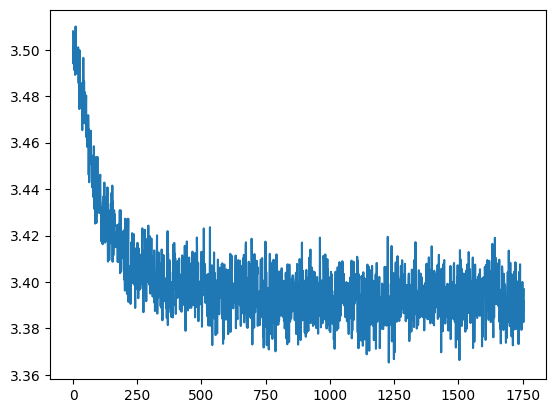

In [67]:
plt.plot(losses)

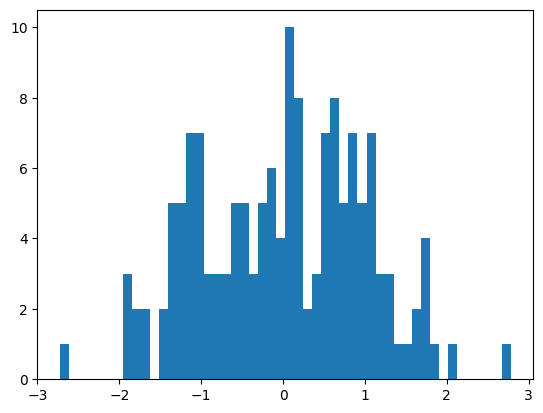

In [68]:
plt.hist(hpreact.view(-1).tolist(), 50);

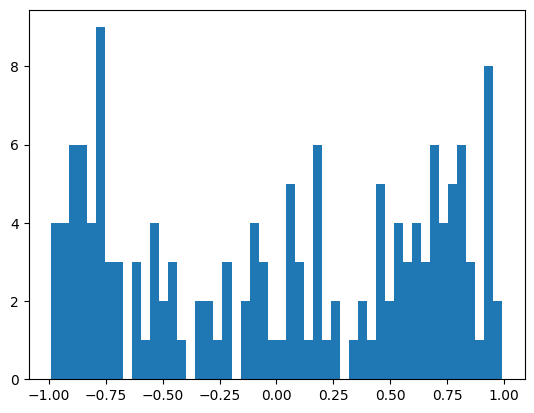

In [69]:
plt.hist(h.view(-1).tolist(), 50);

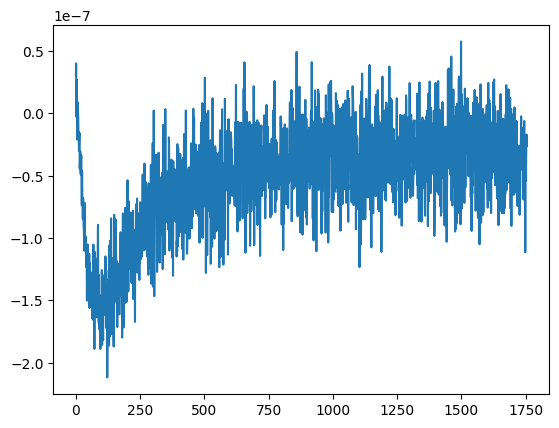

In [70]:
plt.plot(avg_grads)

In [74]:
@torch.no_grad()
def split_loss(split):
    Xset,Yset = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xtest, Ytest),
    }[split]

    loss = 0
    for i in range(Xset.shape[0]):
        Xn, Yn = Xset[i], Yset[i]

        h = torch.zeros(hidden_size, 1)
        sample_loss = 0
        time_step = 0
        for x, target in zip(Xn, Yn):
            if x.sum() == 0: break
            time_step += 1
            
            x = x.view(X_size, 1)
            target = target.view(Y_size, 1)
            
            hpreact = Whh @ h + Wxh @ x #+ bh

            # layer norm
            hpreact = lngain * ((hpreact - hpreact.mean(0)) / hpreact.std(0)) + lnbias
            
            h = torch.tanh(hpreact)

            y = Why @ h + by

            sample_loss += F.cross_entropy(y.view(1, Y_size), torch.argmax(target.view(1, Y_size), dim=1))

        sample_loss /= time_step # average loss over all time steps
        loss += sample_loss

    loss /= Xset.shape[0] # average loss over all examples in the set

    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.5606560707092285
val 2.5673179626464844


In [ ]:
# sample from the model
def sample_forward(char, h):
    x = F.one_hot(torch.tensor(char), num_classes=X_size)
    x = x.view(X_size, 1)
    x = x.type(torch.float32)

    hpreact = Whh @ h + Wxh @ x #+ bh

    # layer norm
    hpreact = lngain * ((hpreact - hpreact.mean(0)) / hpreact.std(0)) + lnbias
    
    h = torch.tanh(hpreact)

    y = Why @ h + by
    probs = F.softmax(y, dim=0)

    # sample from the distribution
    char = torch.multinomial(probs.view(1, Y_size), num_samples=1).item()

    return char, h

for _ in range(50):
    char = 26
    h = torch.zeros(hidden_size, 1)

    char, h = sample_forward(char, h)
    print(itoc[char], end='')
    
    while(char != 26):
        char, h = sample_forward(char, h)
        print(itoc[char], end='')

    print()

#### Single layer, hidden_size 500, batch_size 32, 277027 parameters, 100000 iterations
train 13.1760\
val 13.4144\
shadral\
pautenne\
zyourba\
questunn\
ouh\
xaline\
veronipa\
erline\
pondij\
yahon\
lainia\
yahie\
amleeta\
nelada\
cainy\
brignae\
kenite\
eronjeon\
uush\
zanya\
jahnnia\
sanetty\
ialy\
reeol\
cymanto\
zhonal\
frosticko\
genni\
karsyl\
ikab\
derita\
kaniah\
damaid\
tryde\
everew\
laues\
berlad\
mirayle\
westale\
kesun\
greg\
oukela\
indyc\
oheita\
coue\
marainyia\
richnur\
wiudre\
brizin\
tyrinnnawadderro
dakyana
qumana
waneila
temie
jumesh

#### Single layer, hidden_size 300, batch_size 32, 106227 parameters, 22100 iterations
train 12.1858\
val 12.5714\
vondel\
quasti\
carlia\
sabetti\
zeckrion\
welina\
nieclai\
quanaha\
yussis\
mahrick\
temiorancee\
islee\
artie\
wide\
tikon\
idfa\
murion\
yazifa\
hayzen\
yorddeena\
latrea\
javiye\
gurn\
xinda\
cathar\
abbijahlara\
geralina\
zacvir\
divit\
unetta\
quentosia\
khisa\
flerystine\
rasseen\
ajeney\
taniana\
edelynn\
dibeshi\
harperia\
roirl\
hermyan\
xavonna\
kayven\
yledana\
wadderro\
dakyana\
qumana\
waneila\
temie\
jumesh